# **Brain Tumour Segmentation from MRI Scans**

In [2]:
import pandas as pd
from glob import glob
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
import importlib
from tqdm import tqdm

import torch 
from torch.utils import data
from PIL import Image
from torchvision import transforms
import torch.nn as nn
from torch.optim import SGD

from Model import architecture
from Utils import dataset, loss_fns, plotting

importlib.reload(architecture)
importlib.reload(dataset)
importlib.reload(loss_fns)
importlib.reload(plotting)

<module 'Utils.plotting' from '/Users/bence/Documents/Personal Projects/BrainTumour/Utils/plotting.py'>

## **Retrieve and Visualise Images**

In [3]:
base_path = 'lgg-mri-segmentation/kaggle_3m'

train_masks = glob(base_path + '/*/*_mask*')
train_images = [i[:-9] + '.tif' for i in train_masks]

print(len(train_images))
print(len(train_masks))

3929
3929


[1776, 2012, 2173, 2580, 3454]
lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_1.tif
lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_33.tif
lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_20.tif
lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_3.tif
lgg-mri-segmentation/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_6.tif


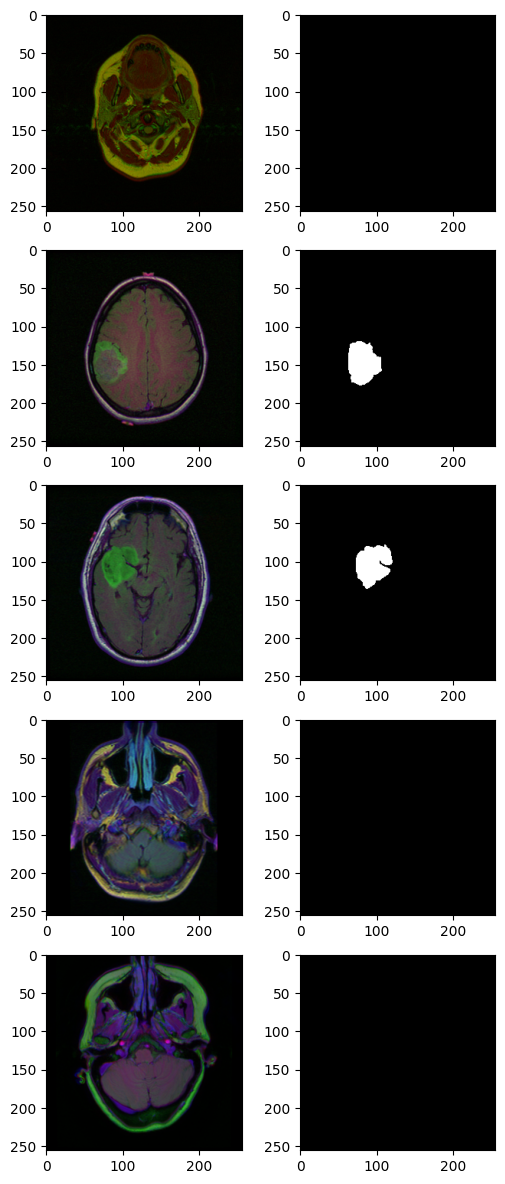

In [4]:
samples = 5
picks = random.sample(range(0, len(train_images)-1), samples)
print(picks)
fig = plt.figure(figsize=(6, 30))

for i in range(1, samples+1):

    img = cv2.imread(train_images[picks[i-1]])
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk = cv2.imread(train_masks[picks[i-1]])

    fig.add_subplot(samples*2, 2,i*2-1)
    #plt.title('Scan')
    plt.imshow(img)

    fig.add_subplot(samples*2, 2, i*2)
    plt.imshow(msk)
    #plt.title(train_images[picks[i-1]])

    print((train_images[picks[i-1]]))



plt.show()

Data Exploration

In [6]:
def get_max(index):
    return np.max([*cv2.imread(train_masks[index]).flatten()])


In [7]:
empties = 0
under_5 = 0

empty_masks = []
empty_images = []
non_empty_masks = []
non_empty_images = []


for i in range(0, len(train_masks)-1):
    if get_max(i) == 0:
        empties += 1
        empty_masks.append(train_masks[i])
        empty_images.append(train_images[i])

    else:
        non_empty_masks.append(train_masks[i])
        non_empty_images.append(train_images[i])



([<matplotlib.patches.Wedge at 0x12dc89760>,
 [Text(-0.5002905735782955, 0.9796475600891885, 'Blank Scans'),
  Text(0.500290573578295, -0.9796475600891889, 'Non-Blank Scans')])

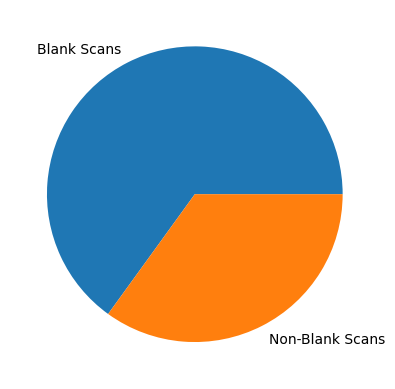

In [31]:
plt.pie([empties, len(train_masks) - empties], labels=['Blank Scans', 'Non-Blank Scans'])

In [9]:
file_list = []
for image, mask in zip(train_images, train_masks):
    result = 0
    if image in non_empty_images:
        result = 1
    file_list.append([image, mask, result])

In [10]:
def run_experiment(model_name, model, optimizer, criterion, train_loader, val_loader, device='mps', num_epochs=50, accuracy_metric = loss_fns.calculate_iou):
    
    # Training

    model.train()

    print('Model sent to ' + str(device))
    model.to(device)

    train_losses = []
    val_losses = []

    train_ious = []
    val_ious = []
    #train_scores = [] 
    iters = 0

    

    for epoch in range(num_epochs):

        running_train_loss = 0.0
        running_iou = 0.0

        print(f"#### Epoch: {epoch} ###")

        
        for num, batch in tqdm(
            enumerate(train_loader),
            desc="Training",
            total=len(train_loader),
            leave=True,
            ncols=80,
        ):
            
            #print(f"Batch: {100* (num/len(train_loader))}")

            img = batch[0].to(device)
            mask = batch[1].to(device)

            optimizer.zero_grad()
            output = model(img)

            loss = criterion(output, mask)
            loss.backward()
            optimizer.step()

            running_train_loss+= loss.item() * img.size(0)
            
            iou = accuracy_metric(output, mask)
            running_iou += iou * img.size(0)

            #train_losses.append(loss.item())
            #train_scores.append(loss_fns.iou_pytorch(output.detach(), mask))

            iters += 1
        
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        print(f'Training Loss: {epoch_train_loss:.4f}')

        epoch_iou = running_iou/len(train_loader.dataset)
        train_ious.append(epoch_iou)
        print(f'Training IOU: {epoch_iou:.4f}')



        # Validation

        model.eval()
        running_val_loss = 0
        running_val_iou = 0.0

        with torch.no_grad():
            

            for batch_idx, batch in tqdm(
                enumerate(val_loader),
                desc="Validating",
                total=len(val_loader),
                leave=True,
                ncols=80,
            ):
                
                img = batch[0].to(device)
                mask = batch[1].to(device)

                output = model(img)

                loss = criterion(output, mask)

                running_val_loss += loss.item() * img.size(0)

                val_iou = accuracy_metric(output, mask)
                running_val_iou += val_iou * img.size(0)
            
            epoch_val_loss = running_val_loss / len(val_loader.dataset)
            val_losses.append(epoch_val_loss)
            print(f'Validation Loss: {epoch_val_loss:.4f}')

            epoch_val_iou = running_val_iou / len(val_loader.dataset)
            val_ious.append(epoch_val_iou)
            print(f'Validation IOU: {epoch_val_iou:.4f}')
                
                
    
    return None

In [11]:
positive_diagnoses = [x for x in file_list if x[2] == 1]
negative_diagnoses = [y for y in file_list if y[2] == 0]
negative_diagnoses_subset = random.sample(negative_diagnoses, int(0.025 * len(negative_diagnoses)))

training_list = positive_diagnoses + negative_diagnoses_subset

transform = transforms.Compose([

    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 0.8))

])

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    #transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 0.8)),
    transforms.ToTensor(),
])

mri_dataset = dataset.MRI_Dataset(positive_diagnoses, transforms=transform)

validation_size = int(0.2 * len(mri_dataset))
test_size = int(0.1 * len(mri_dataset))

train_set, val_set, test_set = data.random_split(mri_dataset, [len(mri_dataset)-validation_size - test_size, validation_size, test_size])

train_loader = data.DataLoader(dataset=train_set, batch_size=2, shuffle=True)
val_loader = data.DataLoader(dataset=val_set, batch_size=2, shuffle=False)
test_loader = data.DataLoader(dataset=test_set, batch_size= 2, shuffle= False)

device = 'mps' if torch.backends.mps.is_available() else 'cpu'

num_epochs = 50

model = architecture.UNet()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()


In [9]:
run_experiment('Unet_SGD', model, optimizer, criterion, train_loader, val_loader, device=device, num_epochs=num_epochs)

Model sent to mps
#### Epoch: 0 ###


Training: 100%|███████████████████████████████| 481/481 [03:55<00:00,  2.05it/s]


Training Loss: 0.0675
Training IOU: 0.0332


Validating: 100%|█████████████████████████████| 137/137 [00:24<00:00,  5.66it/s]


Validation Loss: 0.0505
Validation IOU: 0.0808
#### Epoch: 1 ###


Training: 100%|███████████████████████████████| 481/481 [03:49<00:00,  2.09it/s]


Training Loss: 0.0612
Training IOU: 0.0490


Validating: 100%|█████████████████████████████| 137/137 [00:24<00:00,  5.64it/s]


Validation Loss: 0.0503
Validation IOU: 0.0763
#### Epoch: 2 ###


Training: 100%|███████████████████████████████| 481/481 [03:49<00:00,  2.09it/s]


Training Loss: 0.0497
Training IOU: 0.0680


Validating: 100%|█████████████████████████████| 137/137 [00:24<00:00,  5.68it/s]


Validation Loss: 0.0394
Validation IOU: 0.0866
#### Epoch: 3 ###


Training: 100%|███████████████████████████████| 481/481 [03:50<00:00,  2.09it/s]


Training Loss: 0.0434
Training IOU: 0.0768


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.71it/s]


Validation Loss: 0.0381
Validation IOU: 0.0933
#### Epoch: 4 ###


Training: 100%|███████████████████████████████| 481/481 [03:50<00:00,  2.08it/s]


Training Loss: 0.0383
Training IOU: 0.0852


Validating: 100%|█████████████████████████████| 137/137 [00:24<00:00,  5.71it/s]


Validation Loss: 0.0451
Validation IOU: 0.0482
#### Epoch: 5 ###


Training: 100%|███████████████████████████████| 481/481 [03:50<00:00,  2.09it/s]


Training Loss: 0.0379
Training IOU: 0.0842


Validating: 100%|█████████████████████████████| 137/137 [00:24<00:00,  5.70it/s]


Validation Loss: 0.0344
Validation IOU: 0.0900
#### Epoch: 6 ###


Training: 100%|███████████████████████████████| 481/481 [03:49<00:00,  2.09it/s]


Training Loss: 0.0326
Training IOU: 0.0918


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.73it/s]


Validation Loss: 0.0340
Validation IOU: 0.0715
#### Epoch: 7 ###


Training: 100%|███████████████████████████████| 481/481 [03:49<00:00,  2.09it/s]


Training Loss: 0.0322
Training IOU: 0.0946


Validating: 100%|█████████████████████████████| 137/137 [00:24<00:00,  5.70it/s]


Validation Loss: 0.0273
Validation IOU: 0.0971
#### Epoch: 8 ###


Training: 100%|███████████████████████████████| 481/481 [03:50<00:00,  2.09it/s]


Training Loss: 0.0269
Training IOU: 0.1037


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.71it/s]


Validation Loss: 0.0367
Validation IOU: 0.0676
#### Epoch: 9 ###


Training: 100%|███████████████████████████████| 481/481 [03:49<00:00,  2.09it/s]


Training Loss: 0.0277
Training IOU: 0.1021


Validating: 100%|█████████████████████████████| 137/137 [00:24<00:00,  5.71it/s]


Validation Loss: 0.0228
Validation IOU: 0.1146
#### Epoch: 10 ###


Training: 100%|███████████████████████████████| 481/481 [03:50<00:00,  2.09it/s]


Training Loss: 0.0231
Training IOU: 0.1109


Validating: 100%|█████████████████████████████| 137/137 [00:24<00:00,  5.71it/s]


Validation Loss: 0.0236
Validation IOU: 0.1203
#### Epoch: 11 ###


Training: 100%|███████████████████████████████| 481/481 [03:50<00:00,  2.09it/s]


Training Loss: 0.0217
Training IOU: 0.1143


Validating: 100%|█████████████████████████████| 137/137 [00:24<00:00,  5.70it/s]


Validation Loss: 0.0211
Validation IOU: 0.1112
#### Epoch: 12 ###


Training: 100%|███████████████████████████████| 481/481 [03:50<00:00,  2.09it/s]


Training Loss: 0.0243
Training IOU: 0.1078


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.71it/s]


Validation Loss: 0.0205
Validation IOU: 0.1120
#### Epoch: 13 ###


Training: 100%|███████████████████████████████| 481/481 [03:49<00:00,  2.09it/s]


Training Loss: 0.0212
Training IOU: 0.1139


Validating: 100%|█████████████████████████████| 137/137 [00:24<00:00,  5.71it/s]


Validation Loss: 0.0219
Validation IOU: 0.0953
#### Epoch: 14 ###


Training: 100%|███████████████████████████████| 481/481 [03:50<00:00,  2.09it/s]


Training Loss: 0.0192
Training IOU: 0.1181


Validating: 100%|█████████████████████████████| 137/137 [00:24<00:00,  5.70it/s]


Validation Loss: 0.0183
Validation IOU: 0.1147
#### Epoch: 15 ###


Training: 100%|███████████████████████████████| 481/481 [03:49<00:00,  2.09it/s]


Training Loss: 0.0185
Training IOU: 0.1194


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.71it/s]


Validation Loss: 0.0168
Validation IOU: 0.1226
#### Epoch: 16 ###


Training: 100%|███████████████████████████████| 481/481 [03:49<00:00,  2.09it/s]


Training Loss: 0.0204
Training IOU: 0.1165


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.73it/s]


Validation Loss: 0.0188
Validation IOU: 0.1202
#### Epoch: 17 ###


Training: 100%|███████████████████████████████| 481/481 [03:49<00:00,  2.09it/s]


Training Loss: 0.0177
Training IOU: 0.1211


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.72it/s]


Validation Loss: 0.0181
Validation IOU: 0.1240
#### Epoch: 18 ###


Training: 100%|███████████████████████████████| 481/481 [03:50<00:00,  2.09it/s]


Training Loss: 0.0168
Training IOU: 0.1232


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.71it/s]


Validation Loss: 0.0201
Validation IOU: 0.1284
#### Epoch: 19 ###


Training: 100%|███████████████████████████████| 481/481 [03:49<00:00,  2.09it/s]


Training Loss: 0.0157
Training IOU: 0.1259


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.71it/s]


Validation Loss: 0.0167
Validation IOU: 0.1248
#### Epoch: 20 ###


Training: 100%|███████████████████████████████| 481/481 [03:49<00:00,  2.09it/s]


Training Loss: 0.0151
Training IOU: 0.1263


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.72it/s]


Validation Loss: 0.0164
Validation IOU: 0.1285
#### Epoch: 21 ###


Training: 100%|███████████████████████████████| 481/481 [03:50<00:00,  2.09it/s]


Training Loss: 0.0152
Training IOU: 0.1266


Validating: 100%|█████████████████████████████| 137/137 [00:24<00:00,  5.71it/s]


Validation Loss: 0.0172
Validation IOU: 0.1250
#### Epoch: 22 ###


Training: 100%|███████████████████████████████| 481/481 [03:49<00:00,  2.10it/s]


Training Loss: 0.0149
Training IOU: 0.1266


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.73it/s]


Validation Loss: 0.0150
Validation IOU: 0.1248
#### Epoch: 23 ###


Training: 100%|███████████████████████████████| 481/481 [03:44<00:00,  2.14it/s]


Training Loss: 0.0138
Training IOU: 0.1289


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.75it/s]


Validation Loss: 0.0150
Validation IOU: 0.1272
#### Epoch: 24 ###


Training: 100%|███████████████████████████████| 481/481 [03:44<00:00,  2.14it/s]


Training Loss: 0.0154
Training IOU: 0.1258


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.73it/s]


Validation Loss: 0.0178
Validation IOU: 0.1143
#### Epoch: 25 ###


Training: 100%|███████████████████████████████| 481/481 [03:44<00:00,  2.14it/s]


Training Loss: 0.0142
Training IOU: 0.1282


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.72it/s]


Validation Loss: 0.0153
Validation IOU: 0.1248
#### Epoch: 26 ###


Training: 100%|███████████████████████████████| 481/481 [03:44<00:00,  2.14it/s]


Training Loss: 0.0133
Training IOU: 0.1302


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.74it/s]


Validation Loss: 0.0149
Validation IOU: 0.1317
#### Epoch: 27 ###


Training: 100%|███████████████████████████████| 481/481 [03:44<00:00,  2.15it/s]


Training Loss: 0.0136
Training IOU: 0.1297


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.75it/s]


Validation Loss: 0.0146
Validation IOU: 0.1230
#### Epoch: 28 ###


Training: 100%|███████████████████████████████| 481/481 [03:44<00:00,  2.14it/s]


Training Loss: 0.0129
Training IOU: 0.1311


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.76it/s]


Validation Loss: 0.0152
Validation IOU: 0.1292
#### Epoch: 29 ###


Training: 100%|███████████████████████████████| 481/481 [03:44<00:00,  2.14it/s]


Training Loss: 0.0123
Training IOU: 0.1326


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.74it/s]


Validation Loss: 0.0142
Validation IOU: 0.1293
#### Epoch: 30 ###


Training: 100%|███████████████████████████████| 481/481 [03:44<00:00,  2.14it/s]


Training Loss: 0.0145
Training IOU: 0.1282


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.74it/s]


Validation Loss: 0.0148
Validation IOU: 0.1247
#### Epoch: 31 ###


Training: 100%|███████████████████████████████| 481/481 [03:44<00:00,  2.14it/s]


Training Loss: 0.0127
Training IOU: 0.1318


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.74it/s]


Validation Loss: 0.0152
Validation IOU: 0.1237
#### Epoch: 32 ###


Training: 100%|███████████████████████████████| 481/481 [03:45<00:00,  2.14it/s]


Training Loss: 0.0122
Training IOU: 0.1324


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.73it/s]


Validation Loss: 0.0137
Validation IOU: 0.1294
#### Epoch: 33 ###


Training: 100%|███████████████████████████████| 481/481 [03:44<00:00,  2.14it/s]


Training Loss: 0.0115
Training IOU: 0.1344


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.72it/s]


Validation Loss: 0.0146
Validation IOU: 0.1331
#### Epoch: 34 ###


Training: 100%|███████████████████████████████| 481/481 [03:44<00:00,  2.14it/s]


Training Loss: 0.0114
Training IOU: 0.1345


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.75it/s]


Validation Loss: 0.0148
Validation IOU: 0.1318
#### Epoch: 35 ###


Training: 100%|███████████████████████████████| 481/481 [03:44<00:00,  2.14it/s]


Training Loss: 0.0118
Training IOU: 0.1342


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.74it/s]


Validation Loss: 0.0136
Validation IOU: 0.1289
#### Epoch: 36 ###


Training: 100%|███████████████████████████████| 481/481 [03:44<00:00,  2.15it/s]


Training Loss: 0.0113
Training IOU: 0.1351


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.75it/s]


Validation Loss: 0.0142
Validation IOU: 0.1258
#### Epoch: 37 ###


Training: 100%|███████████████████████████████| 481/481 [03:44<00:00,  2.15it/s]


Training Loss: 0.0112
Training IOU: 0.1354


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.76it/s]


Validation Loss: 0.0145
Validation IOU: 0.1250
#### Epoch: 38 ###


Training: 100%|███████████████████████████████| 481/481 [03:43<00:00,  2.15it/s]


Training Loss: 0.0108
Training IOU: 0.1362


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.76it/s]


Validation Loss: 0.0146
Validation IOU: 0.1283
#### Epoch: 39 ###


Training: 100%|███████████████████████████████| 481/481 [03:43<00:00,  2.15it/s]


Training Loss: 0.0106
Training IOU: 0.1367


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.74it/s]


Validation Loss: 0.0133
Validation IOU: 0.1298
#### Epoch: 40 ###


Training: 100%|███████████████████████████████| 481/481 [03:44<00:00,  2.15it/s]


Training Loss: 0.0104
Training IOU: 0.1369


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.75it/s]


Validation Loss: 0.0140
Validation IOU: 0.1285
#### Epoch: 41 ###


Training: 100%|███████████████████████████████| 481/481 [03:44<00:00,  2.14it/s]


Training Loss: 0.0100
Training IOU: 0.1383


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.73it/s]


Validation Loss: 0.0143
Validation IOU: 0.1310
#### Epoch: 42 ###


Training: 100%|███████████████████████████████| 481/481 [03:43<00:00,  2.15it/s]


Training Loss: 0.0135
Training IOU: 0.1319


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.75it/s]


Validation Loss: 0.0151
Validation IOU: 0.1300
#### Epoch: 43 ###


Training: 100%|███████████████████████████████| 481/481 [03:44<00:00,  2.15it/s]


Training Loss: 0.0118
Training IOU: 0.1341


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.76it/s]


Validation Loss: 0.0153
Validation IOU: 0.1238
#### Epoch: 44 ###


Training: 100%|███████████████████████████████| 481/481 [03:43<00:00,  2.15it/s]


Training Loss: 0.0103
Training IOU: 0.1375


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.76it/s]


Validation Loss: 0.0134
Validation IOU: 0.1302
#### Epoch: 45 ###


Training: 100%|███████████████████████████████| 481/481 [03:44<00:00,  2.15it/s]


Training Loss: 0.0100
Training IOU: 0.1385


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.75it/s]


Validation Loss: 0.0138
Validation IOU: 0.1277
#### Epoch: 46 ###


Training: 100%|███████████████████████████████| 481/481 [03:45<00:00,  2.13it/s]


Training Loss: 0.0094
Training IOU: 0.1398


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.71it/s]


Validation Loss: 0.0134
Validation IOU: 0.1350
#### Epoch: 47 ###


Training: 100%|███████████████████████████████| 481/481 [03:44<00:00,  2.14it/s]


Training Loss: 0.0094
Training IOU: 0.1404


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.72it/s]


Validation Loss: 0.0130
Validation IOU: 0.1311
#### Epoch: 48 ###


Training: 100%|███████████████████████████████| 481/481 [03:44<00:00,  2.14it/s]


Training Loss: 0.0093
Training IOU: 0.1405


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.73it/s]


Validation Loss: 0.0135
Validation IOU: 0.1342
#### Epoch: 49 ###


Training: 100%|███████████████████████████████| 481/481 [03:44<00:00,  2.15it/s]


Training Loss: 0.0092
Training IOU: 0.1413


Validating: 100%|█████████████████████████████| 137/137 [00:23<00:00,  5.77it/s]

Validation Loss: 0.0137
Validation IOU: 0.1292


In [14]:
# Testing
model = architecture.UNet()
model.load_state_dict(torch.load('Checkpoints/Final_Positive.pt'))
model.to('mps')
model.eval()
running_test_loss = 0
running_test_iou = 0.0

with torch.no_grad():
    

    for batch_idx, batch in tqdm(
        enumerate(test_loader),
        desc="Testing",
        total=len(test_loader),
        leave=True,
        ncols=80,
    ):
        
        img = batch[0].to(device)
        mask = batch[1].to(device)

        output = model(img)

        loss = criterion(output, mask)

        running_test_loss += loss.item() * img.size(0)

        test_iou = loss_fns.calculate_iou(output, mask)
        running_test_iou += test_iou * img.size(0)
    
    test_loss = running_test_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

    test_iou = running_test_iou / len(test_loader.dataset)
    print(f'Test IOU: {test_iou:.4f}')

Testing: 100%|██████████████████████████████████| 69/69 [00:12<00:00,  5.46it/s]

Test Loss: 0.0111
Test IOU: 0.1315


In [72]:
torch.save(model.state_dict(), 'Checkpoints/Final_Positive.pt')

6.247704
11.574559
6.997007
4.306945
10.730763


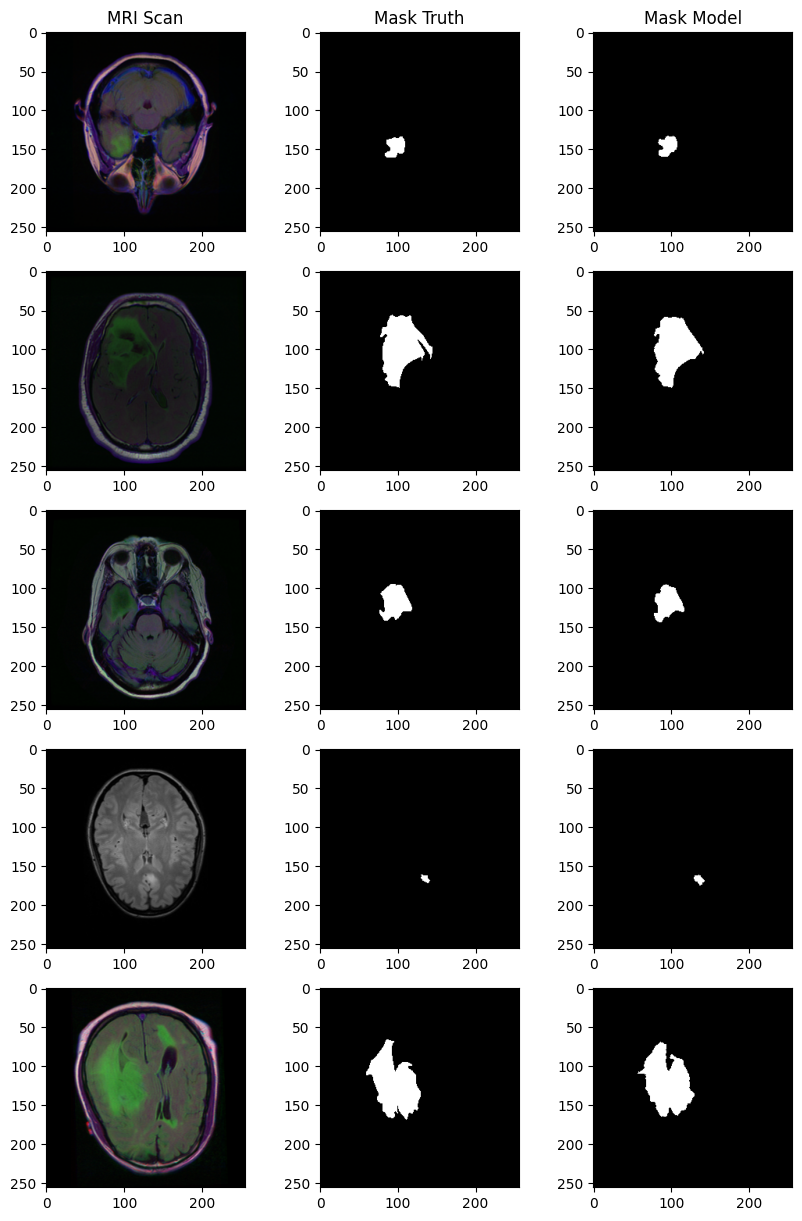

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

UNet(
  (encoder): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05

In [30]:
'''
If using files, below function generates the tensors
'''

plotting.generate_tensors_from_files(1, 2)  

samples = 5
#fig = plt.figure(figsize=(10, 10))

fig, axs = plt.subplots(samples, 3, figsize=(10, 15))

axs[0, 0].set_title('MRI Scan', loc='center')
axs[0, 1].set_title('Mask Truth', loc='center')
axs[0, 2].set_title('Mask Model', loc='center')



for i in range(samples):

    test_in = test_set[i]
    test_img = test_in[0]
    test_mask = test_in[1]

    input_image, ground_truth_mask, predicted_mask = plotting.generate_images(input_img_tensor=test_img, input_mask_tensor=test_mask, model=model)


    # Original input image
    axs[i, 0].imshow(input_image)

    # Ground truth mask
    axs[i, 1].imshow(ground_truth_mask, cmap='gray')

    # Predicted mask
    axs[i, 2].imshow(np.transpose(predicted_mask,(1, 2, 0)), cmap='gray')

plt.show()

model.to('mps')